In [148]:
from collections import Counter
from pandas import DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_validate
import pandas
import matplotlib
from sklearn.model_selection import train_test_split

most_common_duplicates_count = 5
random_state_value = 11

# Data import

In [149]:
input_file = "IMDB Dataset.csv"
data = pandas.read_csv(input_file, header = 0)
original_headers = list(data.columns.values)

# Exploratory data analysis

In [150]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Looking for unique values

In [151]:
for c in categorical_columns:
    print (f"Unique '{c}' values: {len(data[c].unique())}")

Unique 'review' values: 49582
Unique 'sentiment' values: 2


## Analyzing the most common duplicates and removing them

In [152]:
duplicates_counter = Counter(data[data.duplicated()]["review"])
most_common_duplicates = duplicates_counter.most_common(most_common_duplicates_count)
for review, count in most_common_duplicates:
    print('%d : %s \n' % (count + 1, review))
data = data.drop_duplicates(keep='first')

5 : Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed. 

4 : Hilarious, clean, light-hearted, and quote-worthy. What else can you ask for in a film? This is my all-time, number one favorite movie. Ever since I was a little girl, I've dreamed of owning a blue

## Check for empty values

In [153]:
print(data.count(axis=0))

review       49582
sentiment    49582
dtype: int64


# Vectorization

## Replace categories with digits

In [154]:
data.sentiment = data.sentiment.apply(lambda x: 0 if x == "negative" else 1)

In [155]:
print("\n")
print(data.head())



                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1


In [156]:
vectorizer = CountVectorizer()
# vectorizer = CountVectorizer(stop_words="english"б, ngram_range=(1,2), min_df=0.1, max_features = 100000)

## Data split for Train-validate-test pipeline. Proportion is 80/20/20

In [157]:
X = data["review"]
y = data["sentiment"]
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state_value, stratify=y)
X_train, X_validate, y_train, y_validate = train_test_split(X_cv, y_cv, test_size = 0.25, random_state = random_state_value, stratify=y_cv)

## Vocabulary creation

In [158]:
X_train = vectorizer.fit_transform(X_train)
X_validate = vectorizer.transform(X_validate)
X_test = vectorizer.transform(X_test)

# Model training

In [159]:
logreg = LogisticRegression(random_state=random_state_value, max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Cross-validation on validation dataset

In [160]:
scores_validation = cross_validate(logreg, X_validate, y_validate, cv = 5, scoring=("f1", "accuracy", "precision", "recall", "roc_auc"))

In [161]:
def print_cv_score(source, scoreName, abbr):
    print(abbr + ": %0.2f (+/- %0.3f)" % (source[scoreName].mean(), source[scoreName].std() / 2))

print_cv_score(scores_validation, "test_precision", "P")
print_cv_score(scores_validation, "test_recall", "R")
print_cv_score(scores_validation, "test_f1", "F1")
print_cv_score(scores_validation, "test_accuracy", "A")
print_cv_score(scores_validation, "test_roc_auc", "ROC_AUC")

P: 0.86 (+/- 0.005)
R: 0.87 (+/- 0.006)
F1: 0.87 (+/- 0.004)
A: 0.87 (+/- 0.004)
ROC_AUC: 0.93 (+/- 0.003)


# Testing on the independent test set

In [162]:
prediction = logreg.predict(X_test)
print("P : %0.3f" % precision_score(prediction, y_test))
print("R : %0.3f" % recall_score(prediction, y_test))
print("F1: %0.3f" % f1_score(prediction, y_test))
print("A : %0.3f" % accuracy_score(prediction, y_test))
print("ROC_AUC %0.3f: " % roc_auc_score(prediction, y_test))

P : 0.888
R : 0.879
F1: 0.884
A : 0.883
ROC_AUC 0.883: 


In [163]:
# analytics = {}
# vect_validation["CountVectorizer_val_roc_auc"]=scores_validation["test_roc_auc"].mean()
# vect_validation["CountVectorizer_val_f1"]=scores_validation["test_f1"].mean()
# vect_test["CountVectorizer_test_f1"]=f1_score(prediction, y_test)
# vect_test["CountVectorizer_test_roc_auc"]=roc_auc_score(prediction, y_test)
# analytics['CountVectorizer_val'] = vect_validation
# analytics['CountVectorizer_test'] = vect_test

In [164]:
analytics = {}
analytics['CountVectorizer_val'] = scores_validation["test_f1"].mean()
analytics['CountVectorizer_test'] = f1_score(prediction, y_test)

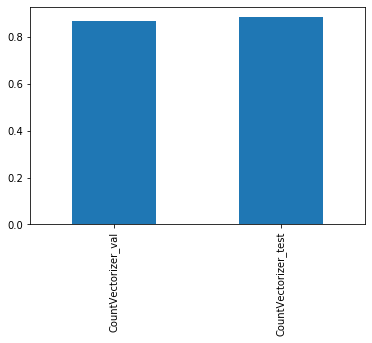

In [165]:
DataFrame.from_dict(data = analytics, orient='index').plot(kind='bar', legend=False)